# Analysis of time-reversed model for oscillatory particle attraction
Tim Tyree<br>
12.13.2021

In [1]:
import cupy as cp, numpy as np
import time
import matplotlib.pyplot as plt
from lib import *
from scipy.signal import savgol_filter
import dask.bag as db
from lib.lib_care.measure.bootstrap import bin_and_bootstrap_xy_values_parallel
darkmode=True
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
    
seed=42
np.random.seed(seed)

For the given phase, $\phi_0$, and for $t'=t_f-t$, the time-reversed problem is

$$
\frac{d\bar R}{dt'} = \frac{2a}{\bar R}\cos(\phi'-\omega t')
$$


We intend to study numerically the mean-squared range (MSR) versus the time leading up to annihilation in the presence of white-noise.  Our stochastic model is

$$
d\bar R = -\frac{2a}{\bar R}\cos(\omega t)dt + \sqrt{4D}dW
$$


# define module

In [2]:
def gener_positions_oscillatory_reversed(
    num_pairs=150, #number of independent pairs of particles
    a=8.5, #cm^2/s known attraction coefficient 
    D=0.3, #cm^2/s known diffusion coefficient
    Dt=1e-5, #s
    initial_phase_orientation=0.,#radians
    period_of_oscillation=90.,#ms
    rstart=1e-4,
    rend=4, #cm
    printing=False,print_every=50000,
    mode='oscillatory',
    use_early_stopping=True,
    **kwargs
    ):
    '''
    Example Usage:
    dict_out,positions_out=gener_positions_oscillatory_reversed(a=a,D=D,initial_phase_orientation=0.,printing=True)
    '''
    dont_break=True
    #initialize particles locations as being at the same locations
    t=0
    x1=0
    x2=np.sqrt(rstart)
    y1=0
    y2=np.sqrt(rstart)
    zero_values=np.zeros(num_pairs)

    x1_values=zero_values.copy()+x1
    x2_values=zero_values.copy()+x2
    y1_values=zero_values.copy()+y1
    y2_values=zero_values.copy()+y2

    stepscale = np.sqrt(2 * D * Dt)
    impulse_prefactor = a * Dt

    tmax=1#10#0.1#1 #seconds
    num_steps=np.int64(np.around(tmax/Dt))

    position_array=np.zeros(shape=(num_steps,4,num_pairs))+np.nan
    mean_array=np.zeros(shape=(num_steps,3))
    std_array=np.zeros(shape=(num_steps,3))

    #add support for still_running
    boo_still_running=zero_values==zero_values

    #compute the distance between each pair of particles
    dx_values=(x2_values-x1_values)
    dy_values=(y2_values-y1_values)
    Rsq_values=dx_values*dx_values+dy_values*dy_values
    omega=((1e-3*period_of_oscillation/(2*np.pi))**-1)
    ##enforces the alignment boundary condition. smart, but might be messing up the oscillations
    #random_time_constant=initial_phase_orientation*omega
    random_time_constant=0.
    if printing:
        print(f"running simulation for {num_steps} steps...")
    start=time.time()
    step_num=0
    while dont_break and (step_num < num_steps):
        t=step_num*Dt + random_time_constant
        #compute the attractive step between all pairs
        f_values=impulse_prefactor/Rsq_values
        F1x=f_values*dx_values
        F1y=f_values*dy_values
        if mode=='oscillatory':
            F1x*=np.sin(omega*t)
            F1y*=np.sin(omega*t)

        #compute the diffusive step between all pairs
        dxW1_values=stepscale*np.random.normal(size=num_pairs)
        dxW2_values=stepscale*np.random.normal(size=num_pairs)
        dyW1_values=stepscale*np.random.normal(size=num_pairs)
        dyW2_values=stepscale*np.random.normal(size=num_pairs)

        #the mean distance between all pairs of particles
        R_values=np.sqrt(Rsq_values)
        mean_R=np.mean(R_values)
        std_R=np.std(R_values)

        #the mean magnitude of the diffusive step
        diffusive_step_values=0.5*np.sqrt(dxW1_values**2+dyW1_values**2)+0.5*np.sqrt(dxW2_values**2+dyW2_values**2)
        mean_diffusive_step=np.mean(diffusive_step_values)
        std_diffusive_step=np.std(diffusive_step_values)

        #the mean magnitude of the attractive step
        attractive_step_values=np.sqrt(F1x**2+F1y**2)
        mean_attractive_step=np.mean(attractive_step_values)
        std_attractive_step=np.std(attractive_step_values)
        if printing:
            if (step_num+1) % print_every == 0:
                relative_percent=100*mean_diffusive_step/mean_attractive_step
                print(f"simulation {100*(step_num+1)/num_steps:.0f}% completed: R={mean_R:.4f}+/-{1.96*std_R:.4f}, diffusion/attraction is {relative_percent:.2f}%")
                # print(f"the mean range is {mean_R:.4f} cm")
                # print(f"the mean diffusive step was {100*mean_diffusive_step/mean_attractive_step:.2f}% larger than the mean attractive step")

        #compute the net change in position (with signs chosed s.t. repulsive at zero phase)
#         x1step_values=F1x+dxW1_values
#         y1step_values=F1y+dyW1_values
#         x2step_values=-F1x+dxW2_values
#         y2step_values=-F1y+dyW2_values
        x1step_values=-F1x+dxW1_values
        y1step_values=-F1y+dyW1_values
        x2step_values=F1x+dxW2_values
        y2step_values=F1y+dyW2_values

        #identify any particles that didn't get within the threshold distance
        #compute the distance between each pair of particles
        dx_values=(x2_values-x1_values)
        dy_values=(y2_values-y1_values)
        Rsq_values=dx_values**2+dy_values**2

        #update particle locations if they are still running
        x1_values[boo_still_running]=x1_values[boo_still_running]+x1step_values[boo_still_running]
        y1_values[boo_still_running]=y1_values[boo_still_running]+y1step_values[boo_still_running]
        x2_values[boo_still_running]=x2_values[boo_still_running]+x2step_values[boo_still_running]
        y2_values[boo_still_running]=y2_values[boo_still_running]+y2step_values[boo_still_running]
        #DONE: verified the mean distance between particles got smaller    
        # if (step_count+1) % save_every == 0:
        #save particle locations to a numpy array with the correct number of positions
        # x1,y1,x2,y2
        position_array[step_num,0,boo_still_running]=x1_values[boo_still_running]
        position_array[step_num,1,boo_still_running]=y1_values[boo_still_running]
        position_array[step_num,2,boo_still_running]=x2_values[boo_still_running]
        position_array[step_num,3,boo_still_running]=y2_values[boo_still_running]
        mean_array[step_num,0]=mean_R
        mean_array[step_num,1]=mean_diffusive_step
        mean_array[step_num,2]=mean_attractive_step
        #save results for quick plotting
        std_array[step_num,0]=std_R
        std_array[step_num,1]=std_diffusive_step
        std_array[step_num,2]=std_attractive_step

    #         #identify any particles that didn't get within the threshold distance
    #         #compute the distance between each pair of particles
    #         dx_values=(x2_values-x1_values)
    #         dy_values=(y2_values-y1_values)
    #         Rsq_values=dx_values*dx_values+dy_values*dy_values
        R_values=np.sqrt(Rsq_values)
        boo_still_running=boo_still_running&(R_values<rend)
        
        step_num+=1
        if use_early_stopping and not boo_still_running.any():
            dont_break=False
    if printing:
        print(f"simulation complete!\nTotal run time: {time.time()-start:.4f} seconds")
        print(f"the number of particles that didn't finished is {sum(boo_still_running)} out of {boo_still_running.shape[0]}.")

    dict_out={
        #         "Gamma_max":np.float32(Gamma_max),
        #         "Gamma_values":Gamma_values.astype('float32'),
        "Rsq_values":Rsq_values.astype('float32'),
        "mean_array":mean_array.astype('float32'),
        "std_array":std_array.astype('float32')
    }
    if printing:
        print(*dict_out)
        #print_dict(dict_out)
    return dict_out,position_array#positions_out

In [3]:
def visualize_model_oscillatory_reversed(ax=None,
    a=1.6,#8.5,
    D=0.6,#0.3,
    initial_phase_orientation=np.pi,#0#np.pi/2,#-np.pi/2,
    period_of_oscillation=90.,
    num_pairs=1000,
    rstart=1e-4,#1.5,
    Dt=1e-5,
    xmin=0,
    xmax=0.1,
    ymin=0,
    ymax=0.6,
    show_inputted_a=True,show_title=True,show_legend=True,use_xylim=True,    
    show_label_black_dotted=False,
    printing=True,
    plotting=True,c='C3',label=r"Simulation",**kwargs):
    """generate MSR using the time-reversed oscillatory model. estimated run time is 15 seconds for 100 statistically independent trials.
    Example Usage:
    dict_fit=visualize_model_oscillatory_reversed(a=1.6,D=0.6,c='C0',label='Fenton-Karma')
    dict_fit=visualize_model_oscillatory_reversed(a=8.5,D=0.3,c='C1',label='Luo-Rudy')
    plt.show()
    """
    dict_out,position_array = gener_positions_oscillatory_reversed(
                a=a, D=D, printing=False,num_pairs=num_pairs,period_of_oscillation=period_of_oscillation,initial_phase_orientation=initial_phase_orientation,**kwargs)
    positions_out=position_array
    if printing:
        print(*dict_out)
        print(f"positions_out.shape={positions_out.shape}")

    title=f"a={a:.1f}, D={D:.1f}, T={period_of_oscillation:.1f},\n"+r"$\phi_0$"+f"={initial_phase_orientation:.4f}, "+r"R$_0$"+f"={rstart:.4f}, "+r" N$_{trials}$"+f"={num_pairs}\n"
    #compute the distance between each pair of particles after aligning by annihilation (unshifted)
    x1_values=positions_out[:,0]
    y1_values=positions_out[:,1]
    x2_values=positions_out[:,2]
    y2_values=positions_out[:,3]
    dx_values=(x2_values-x1_values)
    dy_values=(y2_values-y1_values)
    Rsq_values=dx_values**2+dy_values**2
    #compute the ensemble averaged values
    MSR_values=np.mean(Rsq_values,axis=1)
    aligned_coordinates_values=np.mean(positions_out,axis=-1)
    # maxt=Dt*MSR_values.shape[0]
    t_values=np.arange(MSR_values.shape[0])*Dt
    boo=~(np.isnan(t_values)|np.isnan(MSR_values))
    dict_fit=compute_95CI_ols(t_values[boo],MSR_values[boo])
    if printing:
        print_dict(dict_fit)    
        print(f"num_samples={positions_out.shape[-1]}")
        print(f"num_timepoints={t_values.shape[0]}")
        print(f"ahat = {dict_fit['m']/4:.4f}+/-{dict_fit['Delta_m']/4:.4f}")

    if plotting:
        if ax is None:
            ax=plt.gca()
        xv=np.linspace(xmin,xmax,100)
        if show_inputted_a:
            if show_label_black_dotted:
                ax.plot(xv,4*a*xv,'k--',label=r'$4a(t_f-t)$')
            else:
                ax.plot(xv,4*a*xv,'k--')#,label=r'$4a(t_f-t)$')
        if use_xylim:
            ax.set_xlim([xmin,xmax])
            ax.set_ylim([ymin,ymax])
        ax.plot(t_values,MSR_values,c=c,label=label)
        if show_title:
            plt.title(title,fontsize=16)
        if show_legend:
            plt.legend(fontsize=16)
        #plt.plot(t_values,t_values*0.,'--',c='gray',alpha=0.5)
    return dict_fit

# overlay the MSR of the full model over the MSR from the time-reversed oscillatory model

In [4]:
# # dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.3,c='C1',label='Luo-Rudy')
# dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=0.6,c='C0',label='Fenton-Karma')
# dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.6,c='C1',label='Luo-Rudy')
# format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
# plt.xlim([0,1])
# plt.ylim([0,3])
# plt.show()

In [5]:
#estimate a_sr expected for this value with a sliding window
msr_dir_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/msr_lr_boostrapped_tavg2_14.0_n_2083_a_8.6.csv'
# a_LR = 8.5950#+/-0.3771 cm^2/s
# tavg2=14 ms, num_samples=2083

msr_dir_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/msr_fk_boostrapped_tavg2_14.0_n_19087_a_1.6_tmax_300.csv'
# a_FK = 1.604153#+/-0.040173 cm^2/s
# tavg2=14 ms, num_samples=19087, tmin=0, tmax=300 ms
df_msd_lr=pd.read_csv(msr_dir_lr)
x_values_LR=df_msd_lr['tdeath_avg'].values
y_values_LR=df_msd_lr['MSR'].values
yerr_values_LR=df_msd_lr['Delta_MSR'].values
df_msd_fk=pd.read_csv(msr_dir_fk)
x_values_FK=df_msd_fk['tdeath_avg'].values
y_values_FK=df_msd_fk['MSR'].values
yerr_values_FK=df_msd_fk['Delta_MSR'].values

In [6]:
tmax=300#ms
x_values=x_values_FK.copy()
y_values=y_values_FK.copy()
boo=x_values<tmax #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/4*1e3
Delta_a_SR=dict_a_SR['Delta_m']/4*1e3
print(f"a_hat_FK = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s, tmax={tmax}")
a_hat_FK=a_SR

# tmax=8#ms #gives a nice value
tmax=90#ms
x_values=x_values_LR.copy()
y_values=y_values_LR.copy()
boo=x_values<tmax #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/4*1e3
Delta_a_SR=dict_a_SR['Delta_m']/4*1e3
print(f"a_hat_LR = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s, tmax={tmax}")
a_hat_LR=a_SR

a_hat_FK = 1.604153+/-0.040173 cm^2/s, tmax=300
a_hat_LR = 2.245111+/-0.224026 cm^2/s, tmax=90


Rsq_values mean_array std_array
positions_out.shape=(100000, 4, 1000)
m=6.4161764013482285
Delta_m=0.0057912512063928705
b=0.09666269401785055
Delta_b=0.0012789613141587644
Rsquared=0.9919535769795411
num_samples=1000
num_timepoints=100000
ahat = 1.6040+/-0.0014
Rsq_values mean_array std_array
positions_out.shape=(100000, 4, 1000)
m=14.700496158829495
Delta_m=0.12235349108113178
b=0.09769952622628386
Delta_b=0.005038986361742501
Rsquared=0.8860472480263635
num_samples=1000
num_timepoints=100000
ahat = 3.6751+/-0.0306


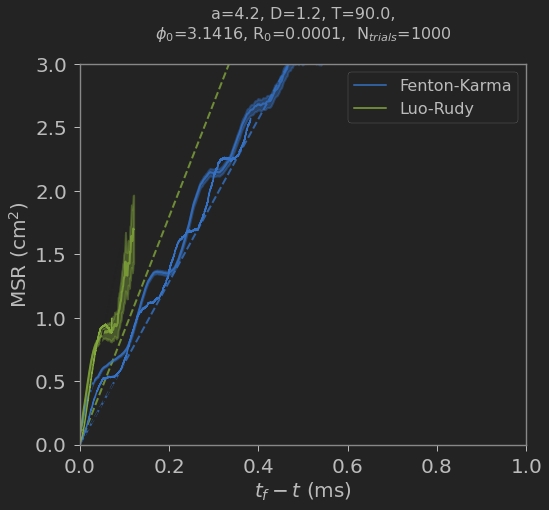

In [7]:
#plot expected
xv=np.linspace(0,1e3,200)
plt.plot(xv,4*a_hat_LR*xv,'--',lw=2,alpha=0.8,c='C1')
plt.plot(xv,4*a_hat_FK*xv,'--',lw=2,alpha=0.8,c='C0')
#plot data
plt.plot(x_values_FK*1e-3,y_values_FK,lw=2,alpha=0.8,c='C0')
plt.fill_between(x_values_FK*1e-3,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
plt.plot(x_values_LR*1e-3,y_values_LR,lw=2,alpha=0.8,c='C1')
plt.fill_between(x_values_LR*1e-3,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')

# dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.3,c='C1',label='Luo-Rudy')
# dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=1.2,c='C0',label='Fenton-Karma')
# dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6*2,D=1.2/2,c='C0',label='Fenton-Karma')
# dict_fit_fk=visualize_model_oscillatory_reversed(a=2.8,D=1.2/2,c='C0',label='Fenton-Karma')#too small of a_FK
# dict_fit_fk=visualize_model_oscillatory_reversed(a=4.,D=1.2/2,c='C0',label='Fenton-Karma')#osc. amplitude too big
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=.8,c='C0',label='Fenton-Karma')

dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5/2,D=1.2,c='C1',label='Luo-Rudy')
plt.xlim([0,1])
plt.ylim([0,3])
plt.show()

Rsq_values mean_array std_array
positions_out.shape=(100000, 4, 1000)
m=6.800586240905328
Delta_m=0.009565946799582553
b=0.09308809071184976
Delta_b=0.0015333370782899614
Rsquared=0.9859027019578133
num_samples=1000
num_timepoints=100000
ahat = 1.7001+/-0.0024
Rsq_values mean_array std_array
positions_out.shape=(100000, 4, 1000)
m=19.514287936425625
Delta_m=0.09346078755790664
b=0.004675694866316249
Delta_b=0.00317296001444714
Rsquared=0.9660873922204763
num_samples=1000
num_timepoints=100000
ahat = 4.8786+/-0.0234


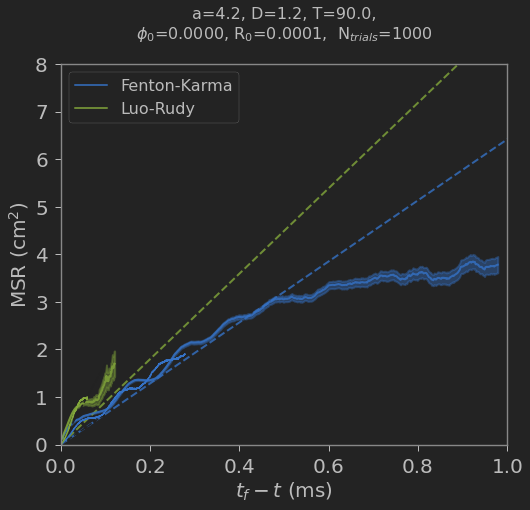

In [8]:
# initial_phase_orientation=-np.pi/2
# initial_phase_orientation=np.pi/2
initial_phase_orientation=0.
# initial_phase_orientation=np.pi

#plot expected
xv=np.linspace(0,1e3,200)
plt.plot(xv,4*a_hat_LR*xv,'--',lw=2,alpha=0.8,c='C1')
plt.plot(xv,4*a_hat_FK*xv,'--',lw=2,alpha=0.8,c='C0')
#plot data
plt.plot(x_values_FK*1e-3,y_values_FK,lw=2,alpha=0.8,c='C0')
plt.fill_between(x_values_FK*1e-3,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
plt.plot(x_values_LR*1e-3,y_values_LR,lw=2,alpha=0.8,c='C1')
plt.fill_between(x_values_LR*1e-3,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')

# dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.3,c='C1',label='Luo-Rudy')
# dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=1.2,c='C0',label='Fenton-Karma')
# dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6*2,D=1.2/2,c='C0',label='Fenton-Karma')
# dict_fit_fk=visualize_model_oscillatory_reversed(a=2.8,D=1.2/2,c='C0',label='Fenton-Karma')#too small of a_FK
# dict_fit_fk=visualize_model_oscillatory_reversed(a=4.,D=1.2/2,c='C0',label='Fenton-Karma')#osc. amplitude too big
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=.8,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')

dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5/2,D=1.2,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
plt.xlim([0,1])
plt.ylim([0,8])
plt.show()

Rsq_values mean_array std_array
positions_out.shape=(100000, 4, 1000)
m=6.30272670215224
Delta_m=0.009419656186769635
b=0.11343859733322992
Delta_b=0.0015710160578545863
Rsquared=0.9834820983860328
num_samples=1000
num_timepoints=100000
ahat = 1.5757+/-0.0024
Rsq_values mean_array std_array
positions_out.shape=(100000, 4, 1000)
m=10.060192903050982
Delta_m=0.05011896744038626
b=0.20887866873401328
Delta_b=0.004976809265011827
Rsquared=0.9000000156140611
num_samples=1000
num_timepoints=100000
ahat = 2.5150+/-0.0125


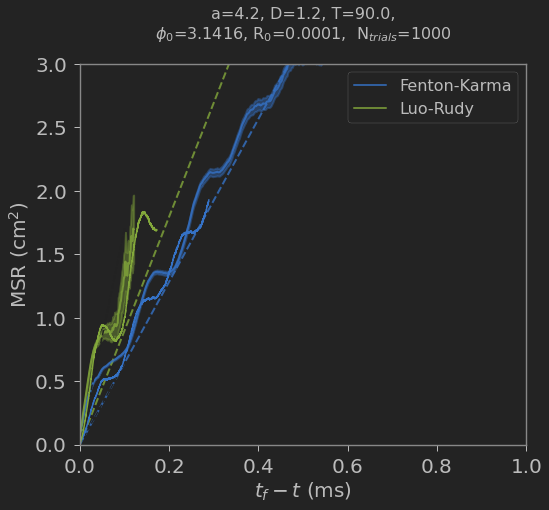

In [9]:
# initial_phase_orientation=-np.pi/2
# initial_phase_orientation=np.pi/2
# initial_phase_orientation=0.
initial_phase_orientation=np.pi

#plot expected
xv=np.linspace(0,1e3,200)
plt.plot(xv,4*a_hat_LR*xv,'--',lw=2,alpha=0.8,c='C1')
plt.plot(xv,4*a_hat_FK*xv,'--',lw=2,alpha=0.8,c='C0')
#plot data
plt.plot(x_values_FK*1e-3,y_values_FK,lw=2,alpha=0.8,c='C0')
plt.fill_between(x_values_FK*1e-3,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
plt.plot(x_values_LR*1e-3,y_values_LR,lw=2,alpha=0.8,c='C1')
plt.fill_between(x_values_LR*1e-3,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')

# dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.3,c='C1',label='Luo-Rudy')
# dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=1.2,c='C0',label='Fenton-Karma')
# dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6*2,D=1.2/2,c='C0',label='Fenton-Karma')
# dict_fit_fk=visualize_model_oscillatory_reversed(a=2.8,D=1.2/2,c='C0',label='Fenton-Karma')#too small of a_FK
# dict_fit_fk=visualize_model_oscillatory_reversed(a=4.,D=1.2/2,c='C0',label='Fenton-Karma')#osc. amplitude too big
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=.8,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5/2,D=1.2,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
plt.xlim([0,1])
plt.ylim([0,3])
plt.show()

Rsq_values mean_array std_array
positions_out.shape=(100000, 4, 1000)
m=6.282976932513051
Delta_m=0.0130492344034526
b=0.09217297376600153
Delta_b=0.0016619392614695499
Rsquared=0.9758305083656102
num_samples=1000
num_timepoints=100000
ahat = 1.5707+/-0.0033
Rsq_values mean_array std_array
positions_out.shape=(100000, 4, 1000)
m=16.003692772402044
Delta_m=0.12740331642030783
b=0.07991894856353299
Delta_b=0.00506012444944287
Rsquared=0.8980954489890148
num_samples=1000
num_timepoints=100000
ahat = 4.0009+/-0.0319


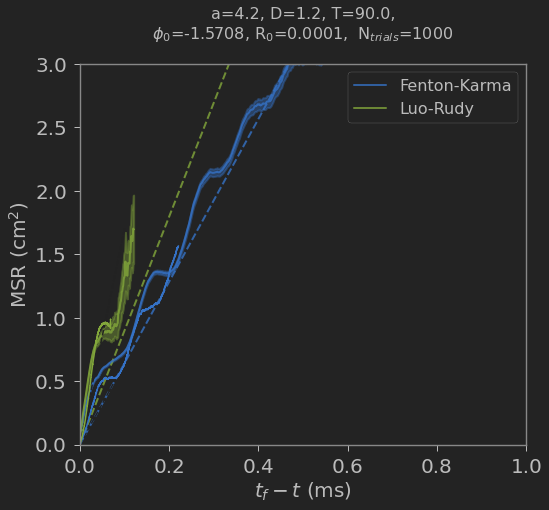

In [10]:
initial_phase_orientation=-np.pi/2
# initial_phase_orientation=np.pi/2
# initial_phase_orientation=0.
# initial_phase_orientation=np.pi

#plot expected
xv=np.linspace(0,1e3,200)
plt.plot(xv,4*a_hat_LR*xv,'--',lw=2,alpha=0.8,c='C1')
plt.plot(xv,4*a_hat_FK*xv,'--',lw=2,alpha=0.8,c='C0')
#plot data
plt.plot(x_values_FK*1e-3,y_values_FK,lw=2,alpha=0.8,c='C0')
plt.fill_between(x_values_FK*1e-3,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
plt.plot(x_values_LR*1e-3,y_values_LR,lw=2,alpha=0.8,c='C1')
plt.fill_between(x_values_LR*1e-3,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')

# dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.3,c='C1',label='Luo-Rudy')
# dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=1.2,c='C0',label='Fenton-Karma')
# dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6*2,D=1.2/2,c='C0',label='Fenton-Karma')
# dict_fit_fk=visualize_model_oscillatory_reversed(a=2.8,D=1.2/2,c='C0',label='Fenton-Karma')#too small of a_FK
# dict_fit_fk=visualize_model_oscillatory_reversed(a=4.,D=1.2/2,c='C0',label='Fenton-Karma')#osc. amplitude too big
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=.8,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')

dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5/2,D=1.2,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
plt.xlim([0,1])
plt.ylim([0,3])
plt.show()

Rsq_values mean_array std_array
positions_out.shape=(100000, 4, 1000)
m=4.925415315530335
Delta_m=0.010713712189598039
b=0.10127105647861179
Delta_b=0.0015378086831877497
Rsquared=0.9702911865960372
num_samples=1000
num_timepoints=100000
ahat = 1.2314+/-0.0027
Rsq_values mean_array std_array
positions_out.shape=(100000, 4, 1000)
m=13.082867082194324
Delta_m=0.2747000858984745
b=0.2518804929366294
Delta_b=0.011760450685970971
Rsquared=0.5402927739640915
num_samples=1000
num_timepoints=100000
ahat = 3.2707+/-0.0687


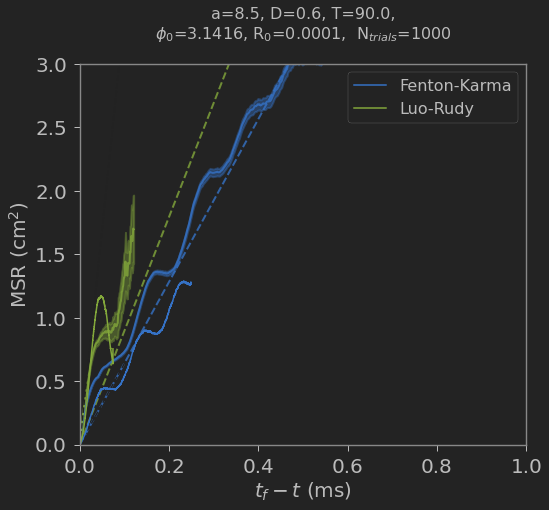

In [11]:
#plot expected
xv=np.linspace(0,1e3,200)
plt.plot(xv,4*a_hat_LR*xv,'--',lw=2,alpha=0.8,c='C1')
plt.plot(xv,4*a_hat_FK*xv,'--',lw=2,alpha=0.8,c='C0')
#plot data
plt.plot(x_values_FK*1e-3,y_values_FK,lw=2,alpha=0.8,c='C0')
plt.fill_between(x_values_FK*1e-3,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
plt.plot(x_values_LR*1e-3,y_values_LR,lw=2,alpha=0.8,c='C1')
plt.fill_between(x_values_LR*1e-3,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
# dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.3,c='C1',label='Luo-Rudy')
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=0.6,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.6,c='C1',label='Luo-Rudy')
plt.xlim([0,1])
plt.ylim([0,3])
plt.show()

# visualize a token trial

Rsq_values mean_array std_array
positions_out.shape=(100000, 4, 1000)
m=4.718811624941654
Delta_m=0.006287384624278545
b=0.09317783890662945
Delta_b=0.001286162596905028
Rsquared=0.9838905550446422
num_samples=1000
num_timepoints=100000
ahat = 1.1797+/-0.0016
Rsq_values mean_array std_array
positions_out.shape=(100000, 4, 1000)
m=9.623273462594728
Delta_m=0.2806502269639241
b=0.35181244543336504
Delta_b=0.01302789719790686
Rsquared=0.3597360822906536
num_samples=1000
num_timepoints=100000
ahat = 2.4058+/-0.0702


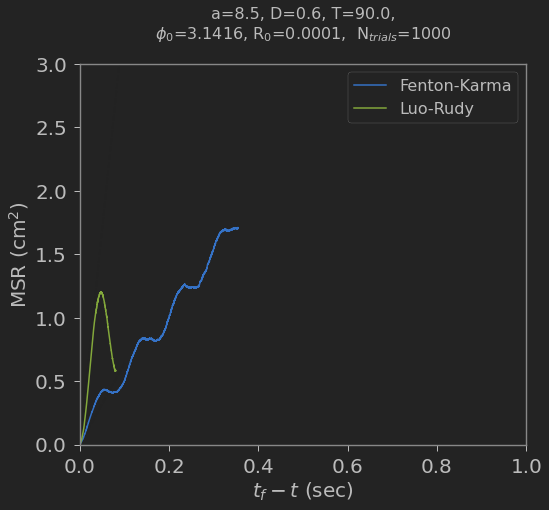

In [12]:
# dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.3,c='C1',label='Luo-Rudy')
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=0.6,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.6,c='C1',label='Luo-Rudy')
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.xlim([0,1])
plt.ylim([0,3])
plt.show()

In [13]:
# dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.3,c='C1',label='Luo-Rudy')
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=0.6,c='C0',label='Fenton-Karma',initial)
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.6,c='C1',label='Luo-Rudy')
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.xlim([0,1])
plt.ylim([0,3])
plt.show()

SyntaxError: positional argument follows keyword argument (2486495213.py, line 2)

In [ ]:
dict_fit_fk=visualize_model_oscillatory_reversed(a=0.,D=0.6,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=0.,D=0.3,c='C1',label='Luo-Rudy')
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.show()

In [ ]:
# dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=0.,c='C0',label='Fenton-Karma')
# dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.,c='C1',label='Luo-Rudy')
# format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
# plt.title(title,fontsize=16)
# plt.legend(fontsize=16)
# plt.show()

In [ ]:
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=0.,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.,c='C1',label='Luo-Rudy')
plt.ylim((0,.05))
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.show()

# show MSR for four most-distant phases

In [ ]:
# initial_phase_orientation=-np.pi/2
# initial_phase_orientation=np.pi/2
initial_phase_orientation=0.
# initial_phase_orientation=np.pi
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=.6,#0,#
                                                 show_label_black_dotted=False,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.6,#,0,#
                                                 show_label_black_dotted=True,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
plt.ylim((0,4))
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.show()

In [ ]:
# initial_phase_orientation=-np.pi/2
# initial_phase_orientation=np.pi/2
# initial_phase_orientation=0.
initial_phase_orientation=np.pi
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=.6,#0,#
                                                 show_label_black_dotted=False,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.6,#,0,#
                                                 show_label_black_dotted=True,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
plt.ylim((0,4))
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.show()

In [ ]:
# initial_phase_orientation=-np.pi/2
initial_phase_orientation=np.pi/2
# initial_phase_orientation=0.
# initial_phase_orientation=np.pi
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=.6,#0,#
                                                 show_label_black_dotted=False,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.6,#,0,#
                                                 show_label_black_dotted=True,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
plt.ylim((0,4))
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.show()

In [ ]:
initial_phase_orientation=-np.pi/2
# initial_phase_orientation=np.pi/2
# initial_phase_orientation=0.
# initial_phase_orientation=np.pi
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=.6,#0,#
                                                 show_label_black_dotted=False,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.6,#,0,#
                                                 show_label_black_dotted=True,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
plt.ylim((0,4))
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.show()

In [ ]:
# initial_phase_orientation=-np.pi/2
initial_phase_orientation=np.pi/2
# initial_phase_orientation=np.pi
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=0,#.6,
                                                 show_label_black_dotted=False,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0,#0.3,
                                                 show_label_black_dotted=True,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
# plt.ylim((0,.2))
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.xlim(0,10)
plt.show()
#heretim

In [ ]:
# initial_phase_orientation=-np.pi/2
#initial_phase_orientation=np.pi/2
initial_phase_orientation=0.
# initial_phase_orientation=np.pi
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=0,#0.6,
                                                 show_label_black_dotted=False,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0,#0.3,
                                                 show_label_black_dotted=True,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
# plt.ylim((0,.2))
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
# plt.title(title,fontsize=16)
# plt.legend(fontsize=16)
plt.show()

In [ ]:
# initial_phase_orientation=-np.pi/2
# #initial_phase_orientation=np.pi/2
# # initial_phase_o|rientation=0.
initial_phase_orientation=np.pi
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=0,#0.6,
                                                 show_label_black_dotted=False,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0,#0.3,
                                                 show_label_black_dotted=True,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
# plt.ylim((0,.2))
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
# plt.title(title,fontsize=16)
# plt.legend(fontsize=16)
plt.show()

## repeat without diffusion

In [ ]:
# initial_phase_orientation=-np.pi/2
# #initial_phase_orientation=np.pi/2
initial_phase_orientation=np.pi
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=0.,show_label_black_dotted=False,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.,show_label_black_dotted=True,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
# plt.ylim((0,.2))
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
# plt.title(title,fontsize=16)
# plt.legend(fontsize=16)
plt.show()

In [ ]:
# initial_phase_orientation=-np.pi/2
# #initial_phase_orientation=np.pi/2
initial_phase_orientation=0.
# initial_phase_orientation=np.pi
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=0.,show_label_black_dotted=False,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.,show_label_black_dotted=True,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
# plt.ylim((0,.2))
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
# plt.title(title,fontsize=16)
# plt.legend(fontsize=16)
plt.show()

In [ ]:
# initial_phase_orientation=-np.pi/2
initial_phase_orientation=np.pi/2
# initial_phase_orientation=np.pi
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=0.,show_label_black_dotted=False,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.,show_label_black_dotted=True,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
# plt.ylim((0,.2))
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
# plt.title(title,fontsize=16)
# plt.legend(fontsize=16)
plt.show()

In [ ]:
initial_phase_orientation=-np.pi/2
# initial_phase_orientation=np.pi/2
# initial_phase_orientation=np.pi
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=0.,show_label_black_dotted=False,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.,show_label_black_dotted=True,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
# plt.ylim((0,.2))
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
# plt.title(title,fontsize=16)
# plt.legend(fontsize=16)
plt.show()

# Visualize a number of trials, so as to paint a picture in terms of the full models

In [ ]:
1

In [ ]:
#estimated run time: 11 minutes
testing=True
if testing:
    #2 min. runtime
    a=8.5
    D=0.3
    num_pairs=400#2min 22sec: 100#1min 30sec: 10+1
    initial_phase_orientation=-np.pi/2
    #initial_phase_orientation=np.pi/2
    # initial_phase_orientation=np.pi
    #rstart=0.01#1.5,rstart=rstart
    #before, long runtime
    dict_out,position_array = gener_positions_oscillatory_reversed(
                a=a, D=D, printing=False,num_pairs=num_pairs,initial_phase_orientation=initial_phase_orientation)
    print(*dict_out)
    print(f"positions_out.shape={positions_out.shape}")
    beep(5)

In [ ]:
# positions_out=dict_out['positions_out']
Dt=1e-5
rstart=1e-4
title=f"a={a:.4f}, D={D:.4f},\n"+r"$\phi_0$"+f"={initial_phase_orientation:.4f}, "+r"R$_0$"+f"={rstart:.4f}, "+r" N$_{trials}$"+f"={num_pairs}\n"

print(f"positions_out.shape={positions_out.shape}")
#compute the distance between each pair of particles after aligning by annihilation (unshifted)
x1_values=positions_out[:,0]
y1_values=positions_out[:,1]
x2_values=positions_out[:,2]
y2_values=positions_out[:,3]
dx_values=(x2_values-x1_values)
dy_values=(y2_values-y1_values)
Rsq_values=dx_values**2+dy_values**2
#compute the ensemble averaged values
MSR_values=np.mean(Rsq_values,axis=1)
aligned_coordinates_values=np.mean(positions_out,axis=-1)
# maxt=Dt*MSR_values.shape[0]
t_values=np.arange(MSR_values.shape[0])*Dt
# x_values=aligned_mean_values[:,0]
# plt.plot(aligned_mean_values[:,1])
# plt.plot(aligned_mean_values[:,2])
# plt.plot(aligned_mean_values[:,3])

xmin,xmax=0,0.1
ymin,ymax=0,0.6
xv=np.linspace(xmin,xmax,100)
plt.plot(xv,4*a*xv,'k--',label=r'$4a(t_f-t)$')
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.plot(t_values,MSR_values,c='C5',label=r"Simulation")
# plt.plot(t_values,aligned_mean_values[::-1,0]**2)
plt.plot(t_values,t_values*0.,'--',c='gray',alpha=0.5)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.title(title,fontsize=16)
plt.legend(fontsize=16)
plt.show()

In [ ]:
boo=~(np.isnan(t_values)|np.isnan(MSR_values))
dict_fit=compute_95CI_ols(t_values[boo],MSR_values[boo])
print_dict(dict_fit)
print(f"num_samples={positions_out.shape[-1]}")
print(f"num_timepoints={t_values.shape[0]}")
print(f"ahat = {dict_fit['m']/4:.4f}+/-{dict_fit['Delta_m']/4:.4f}")